Εδω χτίζω μοντέλο autoencoder με bottleneck που έχει το μισό αριθμό νευρώνων για input, το εκπαιδεύω και αποθηκεύω σε αρχείο το μοντέλο απο το bottleneck και πριν, δηλαδή μόνο το encoding τμήμα που θα κάνει μείωση των διαστάσεων (y=G1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
# load numpy array from npy file
from numpy import load
# load array
X = load('X_G1iter.npy') #data scaled with MinMaxScaaler and imputed with iterative imputer
y = load('y_G1.npy')

### prepare data fo model

In [6]:
# number of input columns
n_inputs = X.shape[1]
print(n_inputs)

667


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [9]:
print(X.shape,y.shape,X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1838, 667) (1838,) (1470, 667) (1470,) (368, 667) (368,)


### Build layers

In [10]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [11]:
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

In [12]:
# bottleneck
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

In [13]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [14]:
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

In [15]:
# output layer
output = Dense(n_inputs, activation='linear')(d)

### compile

In [16]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [17]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

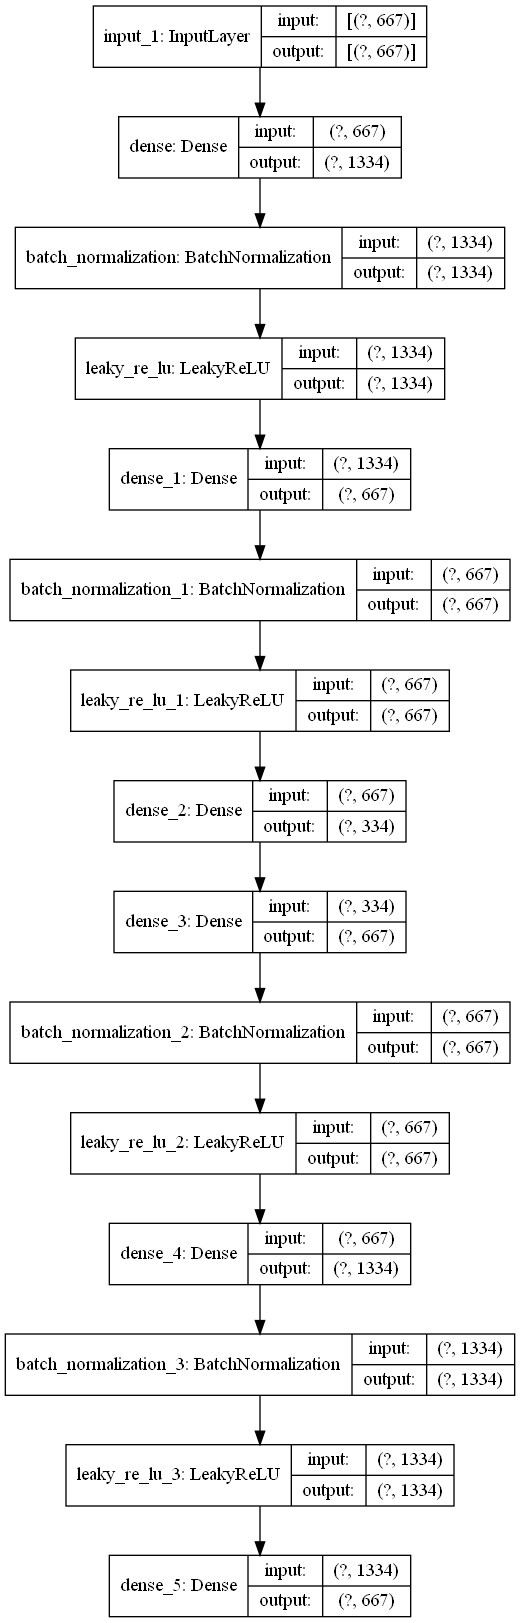

In [18]:
# plot the autoencoder
plot_model(model, 'autoencoder_compressG1.png', show_shapes=True)

### FIT

#### χρησιμοποιησα το validation split και οχι το validation_data, γτ φαινεται πως μαλλον το validation(Χ_test) και το training dataset (X_train)δεν ειναι το ιδιο αντιπροσωπευτικα 

In [19]:
history = model.fit(X_train,X_train, epochs=80, batch_size=16, verbose=0,validation_split=0.2)

#### Evaluate με test set

##### The returned value of model.evaluate does contain loss and metrics. If it doesn't, the model wasn't compiled with metric, αλλα επισης μαλλον ισχυει: the accuracy function/metric in Keras is meant to be used with classification problems. It doesn't make any sense in this case. A better metric/loss is the mean squared error, because you're reconstructing the same features rather than predicting a class

In [20]:
model.evaluate(X_test, X_test,verbose=1)

368/368 [==============================] - 0s 507us/sample - loss: 0.0169


0.016941106108867603

### plots for metrics

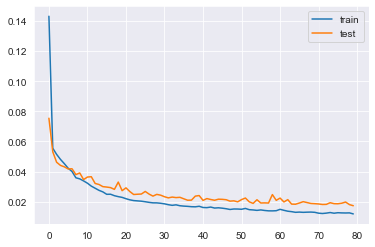

In [21]:
# plot 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['mse'], label='mse') #to mse einai idio me to loss
plt.legend()
plt.show()


#### define an encoder model (without the decoder) & save to file

In [22]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compressG1.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder_halfG1.tf')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder_halfG1.tf\assets


#### define an encoder model (without the decoder) & save to file

In [23]:
from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [27]:
#see output dimensions
a= np.unique(y) 
a

array([0., 1., 2., 3., 4.])

In [28]:
# encode the train data
X_train_encode = encoder.predict(X_train)

# encode the test data
X_test_encode = encoder.predict(X_test)

print(X_train_encode.shape,X_test_encode.shape)

#bilding NN with best hyperparameters found in gridsearch with batch normalization
best_model = Sequential()
best_model.add(Dense(32, 
                kernel_initializer='he_normal', 
                activation='tanh'))
best_model.add(BatchNormalization())        
for i in range(3): # Add 3 hidden layers
    best_model.add(Dense(8, 
                    kernel_initializer='he_normal',
                    activation='tanh'))
        
        # Add output layer 
best_model.add(Dense(5, activation='softmax'))
    
    # Compile model
best_model.compile(optimizer='sgd', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])

#fit NN with data encoded with encoder model
history2 = best_model.fit(X_train_encode,y_train, batch_size=16, epochs=40, verbose=0,validation_split=0.3)

#make prediction
y_classes =best_model.predict_classes(X_test_encode,verbose=1)

#print accracy of NN model to see if encoder enhanced performance, which it didn't
print('Accuracy score for encoder: %.3f ' % accuracy_score(y_test,y_classes))

(1470, 334) (368, 334)
368/368 [==============================] - 0s 238us/sample
Accuracy score for encoder: 0.834 


In [29]:
print(history2.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


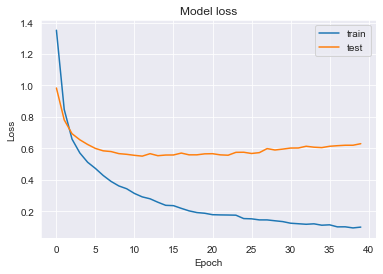

In [30]:
# plot learning curves
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

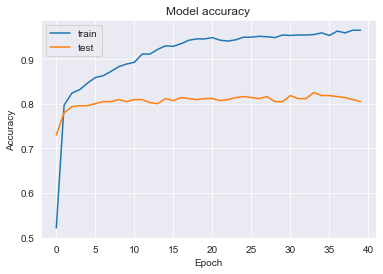

In [31]:
# plot learning curves
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2.history['sparse_categorical_accuracy'], label='train')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.show()

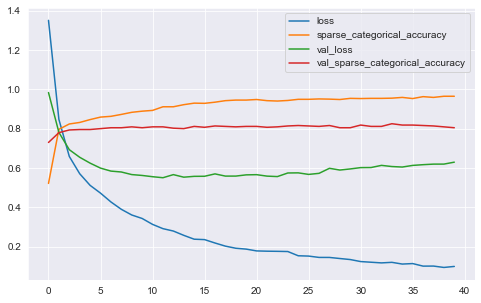

In [32]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

In [34]:
print('\n',confusion_matrix(y_test, y_classes))
print('\n',classification_report(y_test, y_classes))


 [[284  24   0   0   0]
 [ 20  22   0   0   0]
 [  4   9   1   0   0]
 [  0   2   0   0   0]
 [  0   1   1   0   0]]

               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       308
         1.0       0.38      0.52      0.44        42
         2.0       0.50      0.07      0.12        14
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         2

    accuracy                           0.83       368
   macro avg       0.36      0.30      0.30       368
weighted avg       0.83      0.83      0.83       368



C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
